In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from PIL import Image
import cv2
import os
from lxml import etree
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.style.use("seaborn-white")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plt.rcParams["font.sans-serif"]=["SimHei"]
plt.rcParams["axes.unicode_minus"]=False

In [3]:
year = 2007
root_path = r"C:\Users\98311\Downloads\VOCtrainval_06-Nov-2007\VOCdevkit"
data_path = f"VOC{year}"
image_path = f"{root_path}/{data_path}/JPEGImages"
annotation_path = f"{root_path}/{data_path}/Annotations"
train_path = f"{root_path}/{data_path}/ImageSets/Main/train.txt"
# os.path.exists(image_path), os.path.exists(annotation_path)

(True, True)

In [4]:
with open(train_path) as f:
    train_xml_list = [f"{annotation_path}/{line.strip()}.xml" for line in f.readlines()]
f.close()
train_xml_list[:5]

['C:\\Users\\98311\\Downloads\\VOCtrainval_06-Nov-2007\\VOCdevkit/VOC2007/Annotations/000012.xml',
 'C:\\Users\\98311\\Downloads\\VOCtrainval_06-Nov-2007\\VOCdevkit/VOC2007/Annotations/000017.xml',
 'C:\\Users\\98311\\Downloads\\VOCtrainval_06-Nov-2007\\VOCdevkit/VOC2007/Annotations/000023.xml',
 'C:\\Users\\98311\\Downloads\\VOCtrainval_06-Nov-2007\\VOCdevkit/VOC2007/Annotations/000026.xml',
 'C:\\Users\\98311\\Downloads\\VOCtrainval_06-Nov-2007\\VOCdevkit/VOC2007/Annotations/000032.xml']

In [62]:
def get_xml_dict(xml: etree._Element):
    if len(xml) == 0:
        return {xml.tag: xml.text}
    xml_dict = {}
    for node in xml:
        node_dict = get_xml_dict(node)
        if node.tag != 'object':
            xml_dict[node.tag] = node_dict[node.tag]
        else:
            if node.tag not in xml_dict.keys():
                xml_dict[node.tag] = []
            xml_dict[node.tag].append(node_dict[node.tag])
    return {xml.tag:  xml_dict}

In [80]:
with open(train_xml_list[0]) as file:
    xml_str = file.read()
xml = etree.fromstring(xml_str)
xml_dict = get_xml_dict(xml)
file.close()
# xml_dict

In [82]:
train_xml_dicts_list = []
for i in train_xml_list:
    if not os.path.exists(i):
        print(f"{i} is not exists")
    with open(i) as file:
        xml_str = file.read()
    file.close()
    xml = etree.fromstring(xml_str)
    xml_dict = get_xml_dict(xml)['annotation']
    if 'object' not in xml_dict.keys():
        continue
    train_xml_dicts_list.append(xml_dict)
print(len(train_xml_dicts_list))

2501


In [83]:
import json
# get classes
main_path = f"{root_path}/{data_path}/ImageSets/Main"
classes_dict = {}
for txt in os.listdir(main_path):
    cls = txt.split('_')[0]
    if cls not in classes_dict and "txt" not in cls:
        classes_dict[cls] = len(classes_dict) + 1
json_file = json.dumps(classes_dict, sort_keys=True, indent=4)
with open('../datasets/PascalVOC2007/pascal_classes_2007.json', "w") as jf:
    jf.write(json_file)
jf.close()

In [6]:
import torch
import torchvision.transforms as transforms
transform = transforms.Compose([
    transforms.ToTensor(),
])

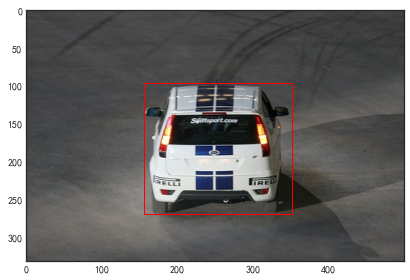

In [131]:
index = 0
xml_dict = train_xml_dicts_list[index]
img = f"{image_path}/{xml_dict['filename']}"
# os.path.exists(image_path)
img = Image.open(img, 'r').convert('RGB')
img = transform(img)
for obj in xml_dict["object"]:
    xmin = float(obj["bndbox"]["xmin"])
    xmax = float(obj["bndbox"]["xmax"])
    ymin = float(obj["bndbox"]["ymin"])
    ymax = float(obj["bndbox"]["ymax"])
height = int(xml_dict['size']['height'])
width = int(xml_dict['size']['width'])
channel = int(xml_dict['size']['depth'])
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor='r')
ax.add_patch(rect)
plt.imshow(img.permute(1, 2, 0))
plt.show()

In [7]:
from data_loader import VOCDataset
import transforms as t

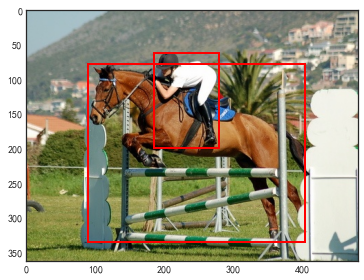

In [8]:
transform = t.Compose([t.ToTensor(), t.RandomHorizontalFlip(prob=0.)])
dataset = VOCDataset(transform=transform)
index = 1
img, target = dataset[index]
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for box in target['boxes']:
    xmin, ymin, xmax, ymax = box
    rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor='r', linewidth=2)
    ax.add_patch(rect)
plt.imshow(img.permute(1, 2, 0))
plt.show()

In [16]:
def plot_anchors(img, target_true, target_pred=None):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    for box in target_true['boxes']:
        xmin, ymin, xmax, ymax = box
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor='r', linewidth=3)
        ax.add_patch(rect)
    if target_true is not None:
        # for box in target_pred['boxes']:
        box = target_pred['boxes'][target_pred['scores'].argmax()]
        xmin, ymin, xmax, ymax = box
        xmax = xmax - xmin
        ymax = ymax - ymin
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor='green',linewidth=1)
        ax.add_patch(rect)
    plt.imshow(img.permute(1, 2, 0))
    plt.show()

In [4]:
class FastRCNNPredictor(nn.Module):
    """
    Standard classification + bounding box regression layers
    for Fast R-CNN.
    Arguments:
        in_channels (int): number of input channels
        num_classes (int): number of output classes (including background)
    """

    def __init__(self, in_channels, num_classes):
        super(FastRCNNPredictor, self).__init__()
        self.cls_score = nn.Linear(in_channels, num_classes)
        self.bbox_pred = nn.Linear(in_channels, num_classes * 4)

    def forward(self, x):
        if x.dim() == 4:
            assert list(x.shape[2:]) == [1, 1]
        x = x.flatten(start_dim=1)
        scores = self.cls_score(x)
        bbox_deltas = self.bbox_pred(x)
        return scores, bbox_deltas

cpu


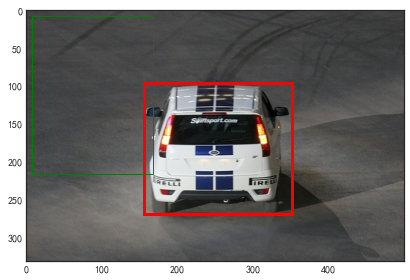

In [17]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
torch.cuda.empty_cache()
device = torch.device('cpu')
model = fasterrcnn_resnet50_fpn(pretrained=True).to(device)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=20).to(device)
model.eval()
x = dataset[0][0].to(device)
target_true = dataset[0][1]
print(x.device)
prediction = model(x[None])
prediction = [{k: v.detach().cpu() for k, v in d.items()}for d in prediction]
plot_anchors(x.detach().cpu(), target_true, prediction[0])
torch.cuda.empty_cache()